## Markov decision process
This week's methods are all built to solve Markov Decision Processes. In the broadest sense, an MDP is defined by how it changes states and how rewards are computed.

State transition is defined by  - how likely are you to end at state  if you take action  from state . Now there's more than one way to define rewards, but we'll use  function for convenience.

In [59]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week02_value_based/mdp.py
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [60]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's2': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

In [61]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


In [62]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ", mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


In [63]:
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
from mdp import has_graphviz
from IPython.display import display
print("Graphviz available:", has_graphviz)

Graphviz available: True


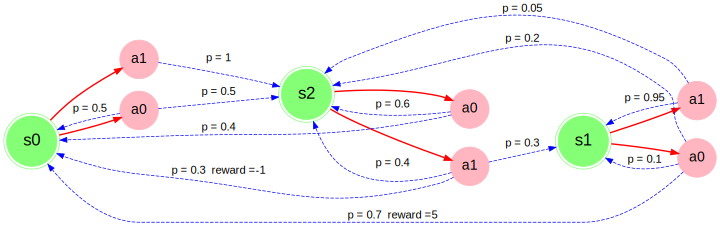

In [65]:
if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values
    display(plot_graph(mdp))

## Value Iteration

In [66]:
import numpy as np

def get_action_value(mdp, state_values, state, action, gamma):
  """ Computes Q(s,a) """
  qsa = 0
  for s in mdp.get_next_states(state, action):
    qsa += mdp.get_transition_prob(state, action, s) * (mdp.get_reward(state, action, s) + gamma*state_values[s])
 
  return qsa

In [67]:
import numpy as np
test_Vs = {s: i for i, s in enumerate(sorted(mdp.get_all_states()))}

assert np.isclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)
assert np.isclose(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9), 3.95)

In [68]:
def get_new_state_value(mdp, state_values, state, gamma):
  """ Computes next V(s). Please do not change state_values in process. """
  if mdp.is_terminal(state):
    return 0 
  state_value = -np.inf
  for action in mdp.get_possible_actions(state):
    state_value = max(state_value, get_action_value(mdp, state_values, state, action, gamma))
  # print(state_value)
  return state_value

In [69]:
test_Vs_copy = dict(test_Vs)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's2', 0.9), 1.08)
assert np.isclose(get_new_state_value(mdp, {'s0': -1e10, 's1': 0, 's2': -2e10}, 's0', 0.9), -13500000000.0), \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"
assert test_Vs == test_Vs_copy, "Please do not change state_values in get_new_state_value"

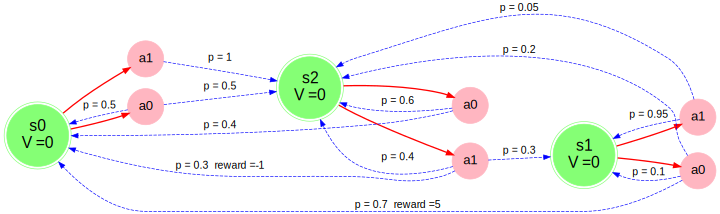

iter    0   |   diff: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000
iter    1   |   diff: 0.64500   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000
iter    2   |   diff: 0.58050   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 0.645
iter    3   |   diff: 0.43582   |   V(s0) = 0.581   V(s1) = 3.959   V(s2) = 0.962
iter    4   |   diff: 0.30634   |   V(s0) = 0.866   V(s1) = 4.395   V(s2) = 1.272
iter    5   |   diff: 0.27571   |   V(s0) = 1.145   V(s1) = 4.670   V(s2) = 1.579
iter    6   |   diff: 0.24347   |   V(s0) = 1.421   V(s1) = 4.926   V(s2) = 1.838
iter    7   |   diff: 0.21419   |   V(s0) = 1.655   V(s1) = 5.169   V(s2) = 2.075
iter    8   |   diff: 0.19277   |   V(s0) = 1.868   V(s1) = 5.381   V(s2) = 2.290
iter    9   |   diff: 0.17327   |   V(s0) = 2.061   V(s1) = 5.573   V(s2) = 2.481
iter   10   |   diff: 0.15569   |   V(s0) = 2.233   V(s1) = 5.746   V(s2) = 2.654
iter   11   |   diff: 0.14012   |   V(s0) = 2.389   V(s1) = 5.902   V(s2) = 2.810
iter   12   |   

In [70]:
# parameters
gamma = 0.9            # discount for MDP
num_iter = 100         # maximum iterations, excluding initialization
# stop VI if new values are this close to old values (or closer)
min_difference = 0.001

# initialize V(s)
state_values = {s: 0 for s in mdp.get_all_states()}

if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

for i in range(num_iter):

    # Compute new state values using the functions you defined above.
    # It must be a dict {state : float V_new(state)}
    new_state_values = {state: get_new_state_value(mdp, state_values, state, gamma) for state in mdp.get_all_states()}

    assert isinstance(new_state_values, dict)

    # Compute difference
    diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())
    print("iter %4i   |   diff: %6.5f   |   " % (i, diff), end="")
    print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
    state_values = new_state_values

    if diff < min_difference:
        print("Terminated")
        break

In [71]:
print("Final state values:", state_values)

assert abs(state_values['s0'] - 3.781) < 0.01
assert abs(state_values['s1'] - 7.294) < 0.01
assert abs(state_values['s2'] - 4.202) < 0.01

Final state values: {'s0': 3.7810348735476405, 's1': 7.294006423867229, 's2': 4.202140275227048}


In [72]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
  """ Finds optimal action using formula above. """
  if mdp.is_terminal(state):
      return None

  state_value = -np.inf
  index = None
  for action in mdp.get_possible_actions(state):
    if get_action_value(mdp, state_values, state, action, gamma) > state_value:
      state_value = get_action_value(mdp, state_values, state, action, gamma)
      index = action

  return index

In [73]:
assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'
assert get_optimal_action(mdp, state_values, 's1', gamma) == 'a0'
assert get_optimal_action(mdp, state_values, 's2', gamma) == 'a1'

assert get_optimal_action(mdp, {'s0': -1e10, 's1': 0, 's2': -2e10}, 's0', 0.9) == 'a0', \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"
assert get_optimal_action(mdp, {'s0': -2e10, 's1': 0, 's2': -1e10}, 's0', 0.9) == 'a1', \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"

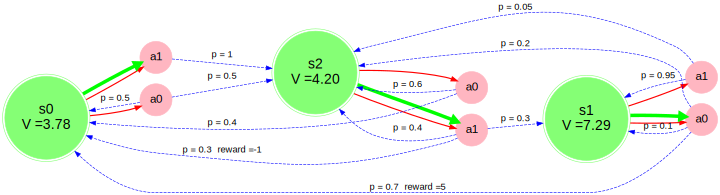

In [74]:
if has_graphviz:
    display(plot_graph_optimal_strategy_and_state_values(mdp, state_values, get_action_value))

In [75]:
# Measure agent's average reward

s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)

print("average reward: ", np.mean(rewards))

assert(0.40 < np.mean(rewards) < 0.55)

average reward:  0.4775


## Frozen Lake

In [76]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [79]:
def value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
  """ performs num_iter value iteration steps starting from state_values. Same as before but in a function """
  state_values = state_values or {s: 0 for s in mdp.get_all_states()}

  for i in range(num_iter):
      # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
      new_state_values = {state: get_new_state_value(mdp, state_values, state, gamma) for state in mdp.get_all_states()}

      assert isinstance(new_state_values, dict)

      # Compute difference
      print(new_state_values, state_values)
      diff = max(abs(new_state_values[s] - state_values[s])
                  for s in mdp.get_all_states())

      print("iter %4i   |   diff: %6.5f   |   V(start): %.3f " %
            (i, diff, new_state_values[mdp._initial_state]))

      state_values = new_state_values
      if diff < min_difference:
          break

  return state_values

In [80]:
state_values = value_iteration(mdp)

{(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.0, (1, 3): 0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.0, (2, 3): 0, (3, 0): 0, (3, 1): 0.0, (3, 2): 1.0, (3, 3): 0} {(0, 0): 0, (0, 1): 0, (0, 2): 0, (0, 3): 0, (1, 0): 0, (1, 1): 0, (1, 2): 0, (1, 3): 0, (2, 0): 0, (2, 1): 0, (2, 2): 0, (2, 3): 0, (3, 0): 0, (3, 1): 0, (3, 2): 0, (3, 3): 0}
iter    0   |   diff: 1.00000   |   V(start): 0.000 
{(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.0, (1, 3): 0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.9, (2, 3): 0, (3, 0): 0, (3, 1): 0.9, (3, 2): 1.0, (3, 3): 0} {(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.0, (1, 3): 0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.0, (2, 3): 0, (3, 0): 0, (3, 1): 0.0, (3, 2): 1.0, (3, 3): 0}
iter    1   |   diff: 0.90000   |   V(start): 0.000 
{(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.81, (1, 3): 0, (2, 0): 0.0, (2, 1

In [81]:
s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done:
        break

*FFF
FHFH
FFFH
HFFG

down

SFFF
*HFH
FFFH
HFFG

down

SFFF
FHFH
*FFH
HFFG

right

SFFF
FHFH
F*FH
HFFG

down

SFFF
FHFH
FFFH
H*FG

right

SFFF
FHFH
FFFH
HF*G

right

SFFF
FHFH
FFFH
HFF*



In [82]:
import matplotlib.pyplot as plt
%matplotlib inline


def draw_policy(mdp, state_values):
    plt.figure(figsize=(3, 3))
    h, w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w, h), cmap='gray', interpolation='none', clim=(0, 1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (0, 1)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y, x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None:
                continue
            u, v = a2uv[a]
            plt.arrow(x, y, u*.3, -v*.3, color='m',
                      head_width=0.1, head_length=0.1)
    plt.grid(color='b', lw=2, ls='-')
    plt.show()

after iteration 0
{(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.0, (1, 3): 0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.0, (2, 3): 0, (3, 0): 0, (3, 1): 0.0, (3, 2): 1.0, (3, 3): 0} {(0, 0): 0, (0, 1): 0, (0, 2): 0, (0, 3): 0, (1, 0): 0, (1, 1): 0, (1, 2): 0, (1, 3): 0, (2, 0): 0, (2, 1): 0, (2, 2): 0, (2, 3): 0, (3, 0): 0, (3, 1): 0, (3, 2): 0, (3, 3): 0}
iter    0   |   diff: 1.00000   |   V(start): 0.000 


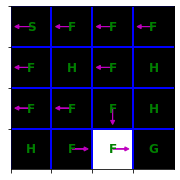

after iteration 1
{(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.0, (1, 3): 0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.9, (2, 3): 0, (3, 0): 0, (3, 1): 0.9, (3, 2): 1.0, (3, 3): 0} {(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.0, (1, 3): 0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.0, (2, 3): 0, (3, 0): 0, (3, 1): 0.0, (3, 2): 1.0, (3, 3): 0}
iter    0   |   diff: 0.90000   |   V(start): 0.000 


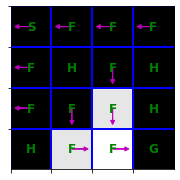

after iteration 2
{(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.81, (1, 3): 0, (2, 0): 0.0, (2, 1): 0.81, (2, 2): 0.9, (2, 3): 0, (3, 0): 0, (3, 1): 0.9, (3, 2): 1.0, (3, 3): 0} {(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.0, (1, 3): 0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.9, (2, 3): 0, (3, 0): 0, (3, 1): 0.9, (3, 2): 1.0, (3, 3): 0}
iter    0   |   diff: 0.81000   |   V(start): 0.000 


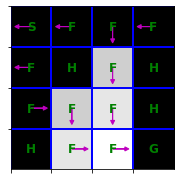

after iteration 3
{(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.7290000000000001, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.81, (1, 3): 0, (2, 0): 0.7290000000000001, (2, 1): 0.81, (2, 2): 0.9, (2, 3): 0, (3, 0): 0, (3, 1): 0.9, (3, 2): 1.0, (3, 3): 0} {(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.81, (1, 3): 0, (2, 0): 0.0, (2, 1): 0.81, (2, 2): 0.9, (2, 3): 0, (3, 0): 0, (3, 1): 0.9, (3, 2): 1.0, (3, 3): 0}
iter    0   |   diff: 0.72900   |   V(start): 0.000 


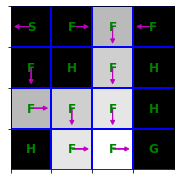

after iteration 4
{(0, 0): 0.0, (0, 1): 0.6561000000000001, (0, 2): 0.7290000000000001, (0, 3): 0.6561000000000001, (1, 0): 0.6561000000000001, (1, 1): 0, (1, 2): 0.81, (1, 3): 0, (2, 0): 0.7290000000000001, (2, 1): 0.81, (2, 2): 0.9, (2, 3): 0, (3, 0): 0, (3, 1): 0.9, (3, 2): 1.0, (3, 3): 0} {(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.7290000000000001, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.81, (1, 3): 0, (2, 0): 0.7290000000000001, (2, 1): 0.81, (2, 2): 0.9, (2, 3): 0, (3, 0): 0, (3, 1): 0.9, (3, 2): 1.0, (3, 3): 0}
iter    0   |   diff: 0.65610   |   V(start): 0.000 


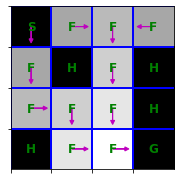

after iteration 5
{(0, 0): 0.5904900000000002, (0, 1): 0.6561000000000001, (0, 2): 0.7290000000000001, (0, 3): 0.6561000000000001, (1, 0): 0.6561000000000001, (1, 1): 0, (1, 2): 0.81, (1, 3): 0, (2, 0): 0.7290000000000001, (2, 1): 0.81, (2, 2): 0.9, (2, 3): 0, (3, 0): 0, (3, 1): 0.9, (3, 2): 1.0, (3, 3): 0} {(0, 0): 0.0, (0, 1): 0.6561000000000001, (0, 2): 0.7290000000000001, (0, 3): 0.6561000000000001, (1, 0): 0.6561000000000001, (1, 1): 0, (1, 2): 0.81, (1, 3): 0, (2, 0): 0.7290000000000001, (2, 1): 0.81, (2, 2): 0.9, (2, 3): 0, (3, 0): 0, (3, 1): 0.9, (3, 2): 1.0, (3, 3): 0}
iter    0   |   diff: 0.59049   |   V(start): 0.590 


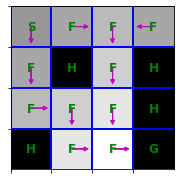

after iteration 6
{(0, 0): 0.5904900000000002, (0, 1): 0.6561000000000001, (0, 2): 0.7290000000000001, (0, 3): 0.6561000000000001, (1, 0): 0.6561000000000001, (1, 1): 0, (1, 2): 0.81, (1, 3): 0, (2, 0): 0.7290000000000001, (2, 1): 0.81, (2, 2): 0.9, (2, 3): 0, (3, 0): 0, (3, 1): 0.9, (3, 2): 1.0, (3, 3): 0} {(0, 0): 0.5904900000000002, (0, 1): 0.6561000000000001, (0, 2): 0.7290000000000001, (0, 3): 0.6561000000000001, (1, 0): 0.6561000000000001, (1, 1): 0, (1, 2): 0.81, (1, 3): 0, (2, 0): 0.7290000000000001, (2, 1): 0.81, (2, 2): 0.9, (2, 3): 0, (3, 0): 0, (3, 1): 0.9, (3, 2): 1.0, (3, 3): 0}
iter    0   |   diff: 0.00000   |   V(start): 0.590 


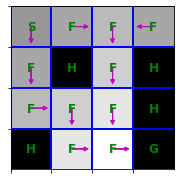

after iteration 7
{(0, 0): 0.5904900000000002, (0, 1): 0.6561000000000001, (0, 2): 0.7290000000000001, (0, 3): 0.6561000000000001, (1, 0): 0.6561000000000001, (1, 1): 0, (1, 2): 0.81, (1, 3): 0, (2, 0): 0.7290000000000001, (2, 1): 0.81, (2, 2): 0.9, (2, 3): 0, (3, 0): 0, (3, 1): 0.9, (3, 2): 1.0, (3, 3): 0} {(0, 0): 0.5904900000000002, (0, 1): 0.6561000000000001, (0, 2): 0.7290000000000001, (0, 3): 0.6561000000000001, (1, 0): 0.6561000000000001, (1, 1): 0, (1, 2): 0.81, (1, 3): 0, (2, 0): 0.7290000000000001, (2, 1): 0.81, (2, 2): 0.9, (2, 3): 0, (3, 0): 0, (3, 1): 0.9, (3, 2): 1.0, (3, 3): 0}
iter    0   |   diff: 0.00000   |   V(start): 0.590 


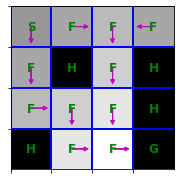

after iteration 8
{(0, 0): 0.5904900000000002, (0, 1): 0.6561000000000001, (0, 2): 0.7290000000000001, (0, 3): 0.6561000000000001, (1, 0): 0.6561000000000001, (1, 1): 0, (1, 2): 0.81, (1, 3): 0, (2, 0): 0.7290000000000001, (2, 1): 0.81, (2, 2): 0.9, (2, 3): 0, (3, 0): 0, (3, 1): 0.9, (3, 2): 1.0, (3, 3): 0} {(0, 0): 0.5904900000000002, (0, 1): 0.6561000000000001, (0, 2): 0.7290000000000001, (0, 3): 0.6561000000000001, (1, 0): 0.6561000000000001, (1, 1): 0, (1, 2): 0.81, (1, 3): 0, (2, 0): 0.7290000000000001, (2, 1): 0.81, (2, 2): 0.9, (2, 3): 0, (3, 0): 0, (3, 1): 0.9, (3, 2): 1.0, (3, 3): 0}
iter    0   |   diff: 0.00000   |   V(start): 0.590 


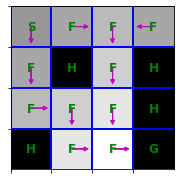

after iteration 9
{(0, 0): 0.5904900000000002, (0, 1): 0.6561000000000001, (0, 2): 0.7290000000000001, (0, 3): 0.6561000000000001, (1, 0): 0.6561000000000001, (1, 1): 0, (1, 2): 0.81, (1, 3): 0, (2, 0): 0.7290000000000001, (2, 1): 0.81, (2, 2): 0.9, (2, 3): 0, (3, 0): 0, (3, 1): 0.9, (3, 2): 1.0, (3, 3): 0} {(0, 0): 0.5904900000000002, (0, 1): 0.6561000000000001, (0, 2): 0.7290000000000001, (0, 3): 0.6561000000000001, (1, 0): 0.6561000000000001, (1, 1): 0, (1, 2): 0.81, (1, 3): 0, (2, 0): 0.7290000000000001, (2, 1): 0.81, (2, 2): 0.9, (2, 3): 0, (3, 0): 0, (3, 1): 0.9, (3, 2): 1.0, (3, 3): 0}
iter    0   |   diff: 0.00000   |   V(start): 0.590 


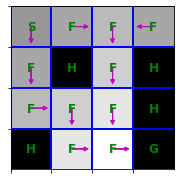

In [83]:
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(10):
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
# please ignore iter 0 at each step

after iteration 29
{(0, 0): 0.1981684335616138, (0, 1): 0.22234453053304482, (0, 2): 0.2493938602121421, (0, 3): 0.2796305131378171, (0, 4): 0.31337222528234676, (0, 5): 0.3501900594269184, (0, 6): 0.39118770221758725, (0, 7): 0.43410192748245174, (1, 0): 0.20337356473110288, (1, 1): 0.22955578700659218, (1, 2): 0.25934276277310475, (1, 3): 0.29368086707410623, (1, 4): 0.34703394392239617, (1, 5): 0.39043262590567285, (1, 6): 0.439376003543815, (1, 7): 0.49007888169577374, (2, 0): 0.1892404212232484, (2, 1): 0.2107255730552412, (2, 2): 0.22752308948428376, (2, 3): 0, (2, 4): 0.3707059345648658, (2, 5): 0.4173224538683299, (2, 6): 0.4935222045991991, (2, 7): 0.5533992739082584, (3, 0): 0.20890903992425222, (3, 1): 0.23700150977169715, (3, 2): 0.2691857278445299, (3, 3): 0.30704795132426943, (3, 4): 0.37907154485655836, (3, 5): 0, (3, 6): 0.55535768747389, (3, 7): 0.6250466757738938, (4, 0): 0.18715573999139046, (4, 1): 0.21063157166003943, (4, 2): 0.22751885941080063, (4, 3): 0, (4, 4):

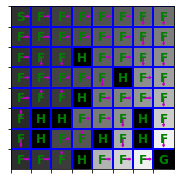

In [84]:
from IPython.display import clear_output
from time import sleep
mdp = FrozenLakeEnv(map_name='8x8', slip_chance=0.1)
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# please ignore iter 0 at each step

In [85]:
mdp = FrozenLakeEnv(slip_chance=0)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(1.0 <= np.mean(total_rewards) <= 1.0)
print("Well done!")

{(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.0, (1, 3): 0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.0, (2, 3): 0, (3, 0): 0, (3, 1): 0.0, (3, 2): 1.0, (3, 3): 0} {(0, 0): 0, (0, 1): 0, (0, 2): 0, (0, 3): 0, (1, 0): 0, (1, 1): 0, (1, 2): 0, (1, 3): 0, (2, 0): 0, (2, 1): 0, (2, 2): 0, (2, 3): 0, (3, 0): 0, (3, 1): 0, (3, 2): 0, (3, 3): 0}
iter    0   |   diff: 1.00000   |   V(start): 0.000 
{(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.0, (1, 3): 0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.9, (2, 3): 0, (3, 0): 0, (3, 1): 0.9, (3, 2): 1.0, (3, 3): 0} {(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.0, (1, 3): 0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.0, (2, 3): 0, (3, 0): 0, (3, 1): 0.0, (3, 2): 1.0, (3, 3): 0}
iter    1   |   diff: 0.90000   |   V(start): 0.000 
{(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.81, (1, 3): 0, (2, 0): 0.0, (2, 1

In [86]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Well done!")

{(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.0, (1, 3): 0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.0, (2, 3): 0, (3, 0): 0, (3, 1): 0.0, (3, 2): 0.9, (3, 3): 0} {(0, 0): 0, (0, 1): 0, (0, 2): 0, (0, 3): 0, (1, 0): 0, (1, 1): 0, (1, 2): 0, (1, 3): 0, (2, 0): 0, (2, 1): 0, (2, 2): 0, (2, 3): 0, (3, 0): 0, (3, 1): 0, (3, 2): 0, (3, 3): 0}
iter    0   |   diff: 0.90000   |   V(start): 0.000 
{(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.0, (1, 3): 0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.7290000000000001, (2, 3): 0, (3, 0): 0, (3, 1): 0.7290000000000001, (3, 2): 0.9405, (3, 3): 0} {(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.0, (1, 3): 0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.0, (2, 3): 0, (3, 0): 0, (3, 1): 0.0, (3, 2): 0.9, (3, 3): 0}
iter    1   |   diff: 0.72900   |   V(start): 0.000 
{(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.

In [87]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.7)
print("Well done!")

{(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.0, (1, 3): 0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.0, (2, 3): 0, (3, 0): 0, (3, 1): 0.0, (3, 2): 0.75, (3, 3): 0} {(0, 0): 0, (0, 1): 0, (0, 2): 0, (0, 3): 0, (1, 0): 0, (1, 1): 0, (1, 2): 0, (1, 3): 0, (2, 0): 0, (2, 1): 0, (2, 2): 0, (2, 3): 0, (3, 0): 0, (3, 1): 0, (3, 2): 0, (3, 3): 0}
iter    0   |   diff: 0.75000   |   V(start): 0.000 
{(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.0, (1, 3): 0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.5062500000000001, (2, 3): 0, (3, 0): 0, (3, 1): 0.5062500000000001, (3, 2): 0.834375, (3, 3): 0} {(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2): 0.0, (1, 3): 0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.0, (2, 3): 0, (3, 0): 0, (3, 1): 0.0, (3, 2): 0.75, (3, 3): 0}
iter    1   |   diff: 0.50625   |   V(start): 0.000 
{(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0, (1, 2)

In [88]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Well done!")

{(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (0, 4): 0.0, (0, 5): 0.0, (0, 6): 0.0, (0, 7): 0.0, (1, 0): 0.0, (1, 1): 0.0, (1, 2): 0.0, (1, 3): 0.0, (1, 4): 0.0, (1, 5): 0.0, (1, 6): 0.0, (1, 7): 0.0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.0, (2, 3): 0, (2, 4): 0.0, (2, 5): 0.0, (2, 6): 0.0, (2, 7): 0.0, (3, 0): 0.0, (3, 1): 0.0, (3, 2): 0.0, (3, 3): 0.0, (3, 4): 0.0, (3, 5): 0, (3, 6): 0.0, (3, 7): 0.0, (4, 0): 0.0, (4, 1): 0.0, (4, 2): 0.0, (4, 3): 0, (4, 4): 0.0, (4, 5): 0.0, (4, 6): 0.0, (4, 7): 0.0, (5, 0): 0.0, (5, 1): 0, (5, 2): 0, (5, 3): 0.0, (5, 4): 0.0, (5, 5): 0.0, (5, 6): 0, (5, 7): 0.0, (6, 0): 0.0, (6, 1): 0, (6, 2): 0.0, (6, 3): 0.0, (6, 4): 0, (6, 5): 0.0, (6, 6): 0, (6, 7): 0.8, (7, 0): 0.0, (7, 1): 0.0, (7, 2): 0.0, (7, 3): 0, (7, 4): 0.0, (7, 5): 0.0, (7, 6): 0.8, (7, 7): 0} {(0, 0): 0, (0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (0, 5): 0, (0, 6): 0, (0, 7): 0, (1, 0): 0, (1, 1): 0, (1, 2): 0, (1, 3): 0, (1, 4): 0, (1, 5): 0, (1, 6): 0, (1, 7): 0, (2, 0): 0, (

## Policy Iteration

In [89]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's1': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

In [112]:
def compute_vpi(mdp, policy, gamma):
    """
    Computes V^pi(s) FOR ALL STATES under given policy.
    :param policy: a dict of currently chosen actions {s : a}
    :returns: a dict {state : V^pi(state) for all states}
    """
    Vpi = {s: 0 for s in mdp.get_all_states()}
    for state in mdp.get_all_states():
      val = 0
      for s in mdp.get_all_states():
        print(mdp.get_transition_prob(state, policy[s], s))
        print(mdp.get_reward(state, policy[s], s))
        print(gamma*Vpi[s])
        val += mdp.get_transition_prob(state, policy[s], s) * (mdp.get_reward(state, policy[s], s) + gamma*Vpi[s])
      Vpi[state] = val
    return Vpi

In [91]:
test_policy = {s: np.random.choice(
    mdp.get_possible_actions(s)) for s in mdp.get_all_states()}
new_vpi = compute_vpi(mdp, test_policy, gamma)

print(new_vpi)

assert type(
    new_vpi) is dict, "compute_vpi must return a dict {state : V^pi(state) for all states}"

{'s0': 0.0, 's1': 3.5, 's2': 1.89}


In [100]:
def compute_new_policy(mdp, vpi, gamma, pi, optimal_policy_found):
    """
    Computes new policy as argmax of state values
    :param vpi: a dict {state : V^pi(state) for all states}
    :returns: a dict {state : optimal action for all states}
    """
    policy = {}
    for s in mdp.get_all_states():
      val = 0
      max_val = vpi[s]
      for a in mdp.get_possible_actions(s):
        val += mdp.get_transition_prob(state, a, s) * (mdp.get_reward(state, a, s) + gamma*vpi[s])
      if val > max_val and pi[s] != a:
        max_val = val
        policy[s] = a
        optimal_policy_found = False
    if optimal_policy_found:
      return policy 

In [101]:
pi = {s: 'a0' for s in mdp.get_all_states()}
optimal_policy_found = True
new_policy = compute_new_policy(mdp, new_vpi, gamma,pi, optimal_policy_found)

print(new_policy)

assert type(
    new_policy) is dict, "compute_new_policy must return a dict {state : optimal action for all states}"

{}


In [110]:
def policy_iteration(mdp, policy=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ 
    Run the policy iteration loop for num_iter iterations or till difference between V(s) is below min_difference.
    If policy is not given, initialize it at random.
    """
    state_values = {s: 0 for s in mdp.get_all_states()}
    policy = {s: np.random.choice(mdp.get_possible_actions(s)) for s in mdp.get_all_states()}

    for i in range(num_iter):
      optimal_policy_found = True

      # policy evaluation

      for j in range(num_iter):
        diff = 0
        new_state_values = {s: 0 for s in mdp.get_all_states()}
        new_state_values = compute_vpi(mdp, policy, gamma)

        assert isinstance(new_state_values, dict)
        # Compute difference
        print(new_state_values, state_values)
        diff = max(abs(new_state_values[s] - state_values[s])
                    for s in mdp.get_all_states())

        print("iter %4i   |   diff: %6.5f   |   V(start): %.3f " %
              (i, diff, new_state_values[mdp._initial_state]))

        state_values = new_state_values
        if diff < min_difference:
            break
    
      # policy iteration
      policy = compute_new_policy(mdp, state_values, gamma, policy, optimal_policy_found)


    return state_values, policy

In [113]:
state_values, policy = policy_iteration(mdp)

0.0
0.0
0.0
0.0
0.0
0.0
1
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.05
0.0
0.0
0.3
-1
0.0
0.6
0.0
0.0
0.4
0.0
0.0
{'s0': 0.0, 's1': 0.0, 's2': -0.3} {'s0': 0, 's1': 0, 's2': 0}
iter    0   |   diff: 0.30000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
1
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.05
0.0
0.0
0.3
-1
0.0
0.6
0.0
0.0
0.4
0.0
0.0
{'s0': 0.0, 's1': 0.0, 's2': -0.3} {'s0': 0.0, 's1': 0.0, 's2': -0.3}
iter    0   |   diff: 0.00000   |   V(start): 0.000 


KeyError: ignored

In [ ]:
s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done:
        break